In [3]:
import sys
sys.path.append('..')

from VarPro import *

# ReLU activation 1D
The model is a SHL with ReLU activation taking inputs in 2d and with features in the unit circle

In [2]:
## Teacher model
activation = nn.ReLU() ## activation function
clipper = FeatureClipper(Normalization())

teacher_width = 4096
teacher = SHL(2, teacher_width, activation, bias=False, clipper=clipper)

gamma = 100 ## Parameter controling the shape of the target distribution

Theta = np.pi * generate_periodic_distribution(teacher_width, dim=1, gamma=gamma).squeeze()
teacher_init = torch.tensor([[np.cos(theta), np.sin(theta)] for theta in Theta], dtype=torch.float32)
#rotation = torch.tensor([[0, -1], [1, 0]], dtype=torch.float32)
#teacher_init[:teacher_width//2] = teacher_init[:teacher_width//2] @ rotation

teacher.feature_model.weight = nn.Parameter(data=teacher_init) ## teacher feature distribution
teacher.outer.weight = nn.Parameter(data=torch.ones_like(teacher.outer.weight), requires_grad=False) ## teacher outer weight

teacher.clipper(teacher)
teacher.apply(freeze)

/Users/rbarboni/Documents/GitHub/VarPro/VarPro_ReLU_1d/../Utilities.py:97: RuntimeWarning: divide by zero encountered in divide
  return 2 * np.arctan( x[:,1] / (1+x[:,0]))


VarProModel(
  (feature_model): SHLFeatureModel(
    (activation): ReLU()
  )
  (outer): Linear(in_features=4096, out_features=1, bias=False)
)

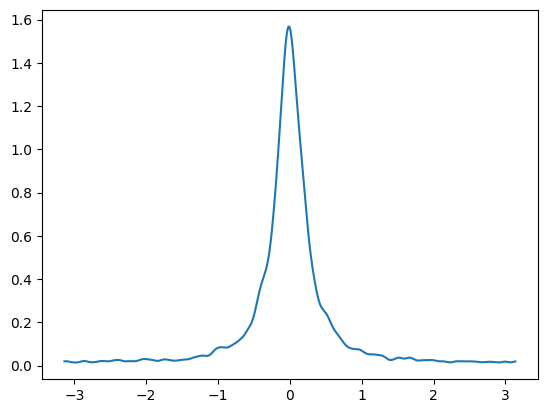

In [3]:
# plot of the teacher feature distribution
f_teacher = circle_to_line(teacher_init.numpy())
plt.plot(*gaussian_conv(f_teacher, scale=0.05))

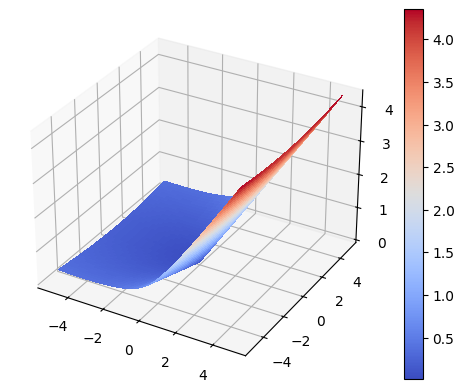

In [7]:
# plot of the teacher signal
_ = model_plot_2d(teacher)

In [5]:
# creating the dataset
N = 4096

inputs = torch.randn(N,2)
targets = teacher(inputs)
dataset = CustomDataset(inputs, targets)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

In [6]:
## Student model
student_width = 1024
#clipper = FeatureClipper(Normalization())

init = torch.randn((student_width, 2), dtype=torch.float32)

student = SHL(2, student_width, activation, bias=False, clipper=clipper, VarProTraining=True)

student.feature_model.weight = nn.Parameter(data=init.clone().detach(), requires_grad=True)
student.clipper(student)

In [7]:
inputs, targets = next(iter(train_loader))
features = student.feature_model(inputs).clone().detach()

K = (features.T @ features) / (N * student_width)
torch.linalg.norm(K, ord=2)

tensor(0.2059)

In [ ]:
## Training
lmbda = 1e-3
time_scale = 2**(-8)
lr = student_width * time_scale

# biased or unbiased loss
criterion = VarProCriterion(lmbda)

## one projection to set-up outer layer
inputs, targets = next(iter(train_loader))
criterion.projection(inputs, targets, student)
                                   
optimizer = torch.optim.SGD([student.feature_model.weight], lr=lr)
#optimizer.add_param_group({'lr': 5*student_width*lmbda, 'params': student.outer.weight})

In [9]:
problem = LearningProblem(student, train_loader, optimizer, criterion)

In [10]:
epochs = 10000
problem.train(epochs)

log10(loss) = -0.30: 100%|██████████| 10000/10000 [05:31<00:00, 30.18it/s]


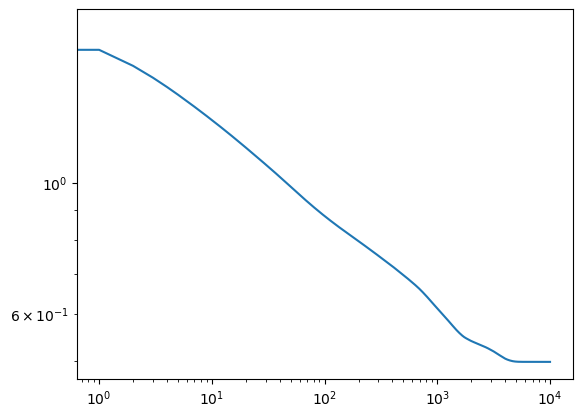

In [12]:
# training loss
plt.plot(problem.loss_list)
plt.yscale('log')
plt.xscale('log')

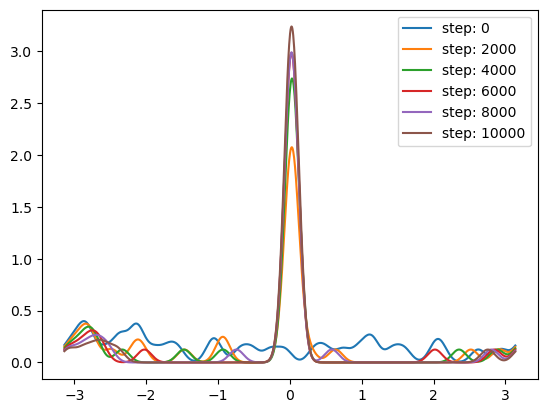

In [30]:
# plot of the learned feature distribution (diracs smoothed with a gaussian)
for i in np.arange(0, 10001, 2000):
    w = problem.state_list[i]['feature_model.weight'].numpy()
    f = circle_to_line(w)
    
    plt.plot(*gaussian_conv(f, scale=0.1), label=f'step: {i}')
plt.legend()
#plt.yscale('log')

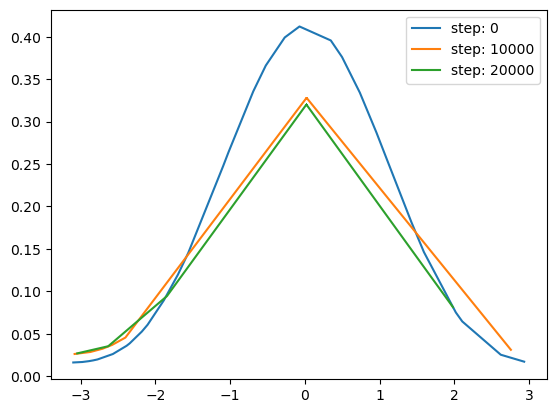

In [37]:
# plot of the outer layer weight (to check if positive and smooth)
for i in np.arange(0, 20001, 10000):
    w = problem.state_list[i]['feature_model.weight'].numpy()
    f = circle_to_line(w)
    idx = np.argsort(f)
    u = problem.state_list[i]['outer.weight'].squeeze().numpy()
    
    plt.plot(f[idx], u[idx], label=f'step: {i}')
#plt.yscale('log')
plt.legend()

#### Distance to the teacher distribution

In [13]:
distance_teacher_list = []
distance_teacher_idx = [int(i) for i in np.linspace(0, len(problem.state_list)-1, 1001)]
for i in tqdm(distance_teacher_idx):
    w1 = problem.state_list[i]['feature_model.weight']
    w2 = teacher.feature_model.weight
    distance_teacher_list.append(compute_distance(DistanceMMD(), w1, w2).item())


100%|██████████| 1001/1001 [00:27<00:00, 36.78it/s]


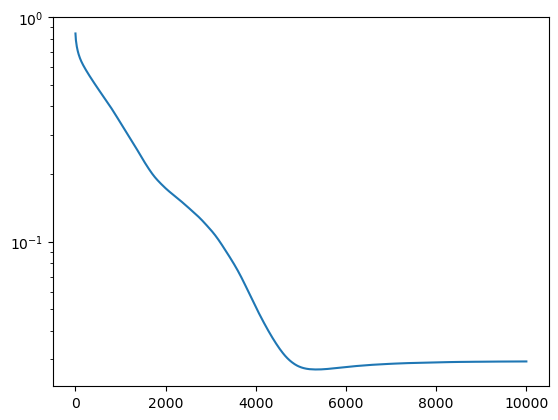

In [14]:
plt.plot(distance_teacher_idx, distance_teacher_list)
plt.yscale('log')

# Exact solution in 1D
Numerical resolution of the weighted ultra-fast diffusion in 1d

In [16]:
import gzip
import pickle

path = '../diffusion_relu1d_gamma100_ts-8.pkl.gz'
with gzip.open(path, 'rb') as file:
    f_list = pickle.load(file)

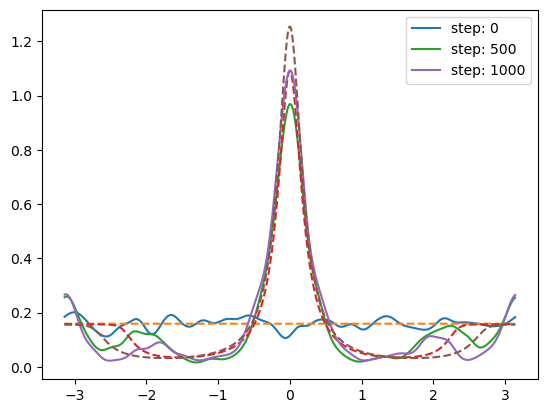

In [23]:
M = f_list.shape[1]
X = np.linspace(-np.pi, np.pi, M+1)
X = 0.5 * (X[1:]+X[:-1])

for i in np.arange(0, 1001, 500):
    w = problem.state_list[i]['feature_model.weight'].numpy()
    f = circle_to_line(w)
    
    plt.plot(*gaussian_conv(f, scale=0.1), label=f'step: {i}')
    plt.plot(X, f_list[i], '--')
plt.legend()
#plt.yscale('log')

In [18]:

w2 = torch.tensor([[np.cos(x), np.sin(x)] for x in X], dtype=torch.float32)

distance_diffusion_list = []
distance_diffusion_idx = [int(i) for i in np.linspace(0, epochs, 1001)]
for i in tqdm(distance_diffusion_idx):
    w1 = problem.state_list[i]['feature_model.weight']
    c2 = torch.tensor(f_list[i],dtype=torch.float32) * 2*np.pi / M
    distance_diffusion_list.append(compute_distance(DistanceMMD(), w1, w2, c2=c2).item())

100%|██████████| 1001/1001 [00:26<00:00, 37.56it/s]


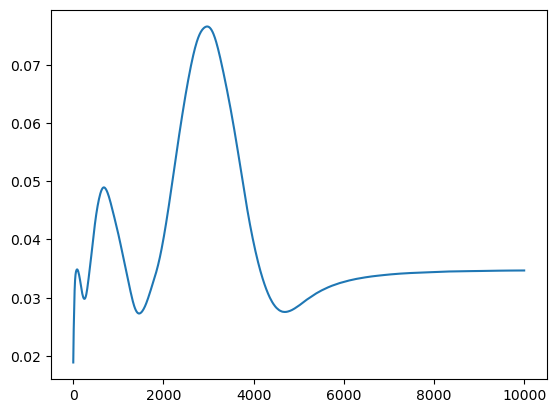

In [19]:
plt.plot(distance_diffusion_idx, distance_diffusion_list)
#plt.yscale('log')

## Compute exact solution

In [26]:
from scipy.integrate import solve_ivp

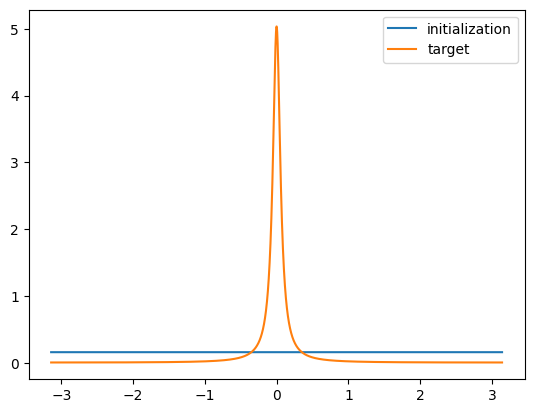

In [27]:
M = 4096
gamma = 1000

X = np.linspace(-np.pi, np.pi, M+1)
X = 0.5 * (X[1:]+X[:-1])

f0 = normalize(np.ones(M)) ## initialization
f_star = normalize(1 / (1 + gamma * np.sin(X/2)**2)) ## target

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(X, f0, label='initialization')
ax.plot(X, f_star, label='target')
plt.legend()
#ax.axis('equal')

In [28]:
def F(t, f):
    return - 0.5 * f * Laplacian((f_star / f)**2, h=2*np.pi/M) - 0.5 * Grad((f_star / f)**2, h=2*np.pi/M) * Grad(f, h=2*np.pi/M)

In [29]:
T = 10000
time_scale = 2**(-10)

t_eval = np.linspace(0, T*time_scale, T+1)
t_span = (0, T*time_scale)
sol1 = solve_ivp(F, t_span, f0, t_eval=t_eval, method='LSODA')

In [31]:
sol2 = solve_ivp(F, t_span, f0, t_eval=t_eval, method='LSODA', rtol=1e-6, atol=1e-9)

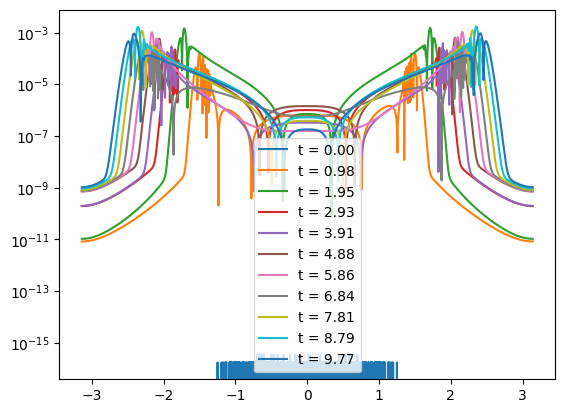

In [34]:
for i in np.arange(0, 10001, 1000):
    plt.plot(X, abs(sol2.y[:,i]-sol1.y[:,i]) / sol1.y[:,i], label=f't = {i*time_scale:.2f}')
    #plt.plot(X, sol1.y[:,i], label=f't = {i*time_scale:.2f}')
plt.legend()
plt.yscale('log')

In [19]:
import gzip
import pickle

path = 'diffusion_relu1d_gamma1000_ts-10.pkl.gz'
with gzip.open(path, 'wb') as file:
    pickle.dump(sol.y.T, file)